# Comparison of Clustering Algorithms for Classifying Breast Cancer Types Based on Proteome Data

In [53]:
%matplotlib inline

In [88]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn import metrics
import re
from sklearn.preprocessing import Imputer
from numpy import random
import seaborn as sb

## 1. Data Pre-processing

In [55]:
dataset_path = "77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "clinical_data_breast_cancer.csv"
pam50_proteins = "PAM50_proteins.csv"

TCGA Ground Truth. 4 different breast cancer subtypes.

In [56]:
pd.DataFrame(processed["PAM50 mRNA"])

,PAM50 mRNA
TCGA-A2-A0CM,Basal-like
TCGA-A2-A0D2,Basal-like
TCGA-A2-A0EQ,HER2-enriched
TCGA-A2-A0EV,Luminal A
TCGA-A2-A0EX,Luminal A
TCGA-A2-A0EY,Luminal B
TCGA-A2-A0SW,Luminal B
TCGA-A2-A0SX,Basal-like
TCGA-A2-A0T3,Luminal B
TCGA-A2-A0T6,Luminal A


In [57]:
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

data.shape # 12553 genes × 85 samples
clinical.shape # 105 sampels x 29 clinical features
pam50 # the 50 genes associated with breast cancer 

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160
5,ACTR3B,NP_065178,Homo sapiens,ARP3 actin-related protein 3 homolog B (yeast)
6,ACTR3B,NP_001035225,Homo sapiens,ARP3 actin-related protein 3 homolog B (yeast)
7,MLPH,NP_001035932,Homo sapiens,melanophilin
8,MLPH,NP_077006,Homo sapiens,melanophilin
9,ERBB2,NP_001005862,Homo sapiens,v-erb-b2 erythroblastic leukemia viral oncogen...


In [58]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)
 
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
data = data.transpose()

## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]
 
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = data.merge(clinical,left_index=True,right_index=True)
 
## Change name to make it look nicer in the code!
processed = merged
 
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]
 
## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
#processed_numerical_p50 = processed_numerical.ix[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]

## Impute missing values (maybe another method would work better?)
imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
imputer = imputer.fit(processed_numerical)
processed_numerical_imputed = imputer.transform(processed_numerical)

processed_numerical_imputed = pd.DataFrame(processed_numerical_imputed, \
                                               columns = processed_numerical.columns, \
                                               index = processed_numerical.index)

In [59]:
processed_numerical_imputed

RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,-0.128444,-0.128444,1.153614,-0.128444,-0.128444,-0.128444,-0.128444,-0.128444,-0.128444,-0.128444
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,0.919136,-1.648856,0.832649,-0.205192,-8.324969,-4.679219,-0.205192,-1.106650,-0.205192,-6.941181
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-0.801685,-0.246756,-0.246756,3.802310,-6.373934,-1.123160,-0.246756,-0.246756,-0.246756,-0.246756
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-4.966177,-1.471027,-0.241563,-0.474013,-12.278546,-10.337729,-0.653251,-0.241563,-0.241563,-0.241563
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,1.451490,-2.018981,0.877456,0.037039,0.037039,-6.101005,0.037039,-1.726336,0.037039,0.037039
TCGA-A2-A0EY,1.174881,1.183209,1.183209,1.174881,1.179045,1.183209,1.183209,1.183209,4.955702,0.825113,...,-0.861266,-0.507334,0.158890,0.158890,4.597606,6.179888,0.158890,0.158890,0.158890,0.158890
TCGA-A2-A0SW,-0.487772,-0.487772,-0.487772,-0.487772,-0.503853,-0.487772,-0.487772,-0.487772,-1.626289,0.731148,...,0.596070,0.969143,-0.056808,-1.053815,-0.056808,-0.056808,-0.056808,-0.056808,-0.056808,-0.056808
TCGA-A2-A0SX,-0.398560,-0.392601,-0.392601,-0.392601,-0.395581,-0.392601,-0.392601,-0.392601,-2.504862,0.694810,...,-0.079784,-0.079784,-0.079784,-0.079784,-0.079784,-0.079784,-0.079784,-0.079784,-0.079784,-0.079784
TCGA-A2-A0T3,0.583713,0.580623,0.580623,0.586803,0.586803,0.586803,0.586803,0.586803,0.052212,1.501479,...,-4.060739,-1.650444,-0.578172,2.017529,-0.111564,-12.265010,-0.111564,-1.264179,-1.100403,-5.590348
TCGA-A2-A0T6,0.793976,0.818182,0.814724,0.800892,0.818182,0.811266,0.811266,0.811266,1.381834,1.565108,...,-4.195908,-2.415042,-0.620344,0.002095,-0.101645,-13.120988,-0.101645,-0.101645,1.181271,-0.101645


In [64]:
processed_numerical_imputed = np.array(processed_numerical_imputed)
pca = PCA(n_components=80)
pca.fit(processed_numerical_imputed)
explained_var = np.array([round(i*100,1) for i in pca.explained_variance_ratio_][:10])
print 'Percent variance explained by top 10 components:'
pd.DataFrame(explained_var.T, columns = ["% Variance Explained"], index = ["PC"+str(i) for i in range(1,11)]).T

Percent variance explained by top 10 components:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
% Variance Explained,14.4,7.1,6.1,3.4,3.3,2.9,2.5,2.2,2,1.9


In [73]:
processed_numerical_imputed_pca = pca.fit_transform(processed_numerical_imputed)
print processed_numerical_imputed_pca.shape
processed_numerical_imputed_pca
pd.DataFrame(processed_numerical_imputed_pca, index = processed_numerical.index, columns = ["PC"+str(i) for i in range(1,81)])

(80, 80)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80
TCGA-A2-A0CM,-21.775542,-14.419141,70.310505,-27.156965,17.704567,-38.966332,7.392024,-10.125037,29.776915,3.286351,...,-3.418577,3.067626,-6.629266,-9.342624,3.006841,-1.110754,-3.503551,0.878910,8.173421,3.032715e-14
TCGA-A2-A0D2,42.462443,5.047470,78.296225,-14.744341,7.877508,-46.413121,-37.705658,12.669875,22.736740,2.805359,...,3.693678,3.889388,-1.363085,-1.163848,2.053136,1.960659,2.071112,-3.895374,2.647965,3.032715e-14
TCGA-A2-A0EQ,-10.462373,-53.206676,55.155270,-64.235594,-44.981165,28.402001,25.866902,5.039292,-5.894639,-6.363681,...,3.861538,-7.051207,0.084099,-2.530148,3.847053,1.126522,1.621315,0.022517,3.680955,3.032715e-14
TCGA-A2-A0EV,149.138405,43.692477,-1.843932,-4.375962,-30.191400,30.746466,-29.627687,-55.152163,-36.354676,16.826334,...,-8.963959,8.079892,35.558348,-8.318586,2.877529,-1.820477,-9.608114,-2.302241,-1.190023,3.032715e-14
TCGA-A2-A0EX,-11.143356,49.168659,-31.445594,15.672279,-20.876903,-70.826899,18.738797,-11.195831,-20.208572,-33.494605,...,-10.859842,6.830331,-0.968072,-2.626331,-1.612126,-1.263346,5.076009,4.800786,-1.603774,3.032715e-14
TCGA-A2-A0EY,-71.966955,52.034837,9.038863,18.766369,-35.677164,22.726583,32.950278,41.039655,41.597845,-14.042543,...,1.415242,3.662196,2.811902,-2.506829,3.379182,-2.044303,-0.091614,0.179991,-2.094109,3.032715e-14
TCGA-A2-A0SW,-12.736108,40.417101,-7.441829,-44.750188,16.507534,37.942335,15.223989,13.415281,28.497804,43.966757,...,-11.482408,-0.162755,1.486148,2.131339,-34.898439,-1.789358,55.717808,-2.038351,0.638770,3.032715e-14
TCGA-A2-A0SX,-19.923845,85.188202,25.247897,-55.734515,37.942842,18.730738,23.020945,0.595122,7.059569,16.191276,...,5.955844,0.789695,-8.535211,-0.126278,4.859738,-3.644285,3.167103,-9.209886,-47.258797,3.032715e-14
TCGA-A2-A0T3,55.480724,7.194919,-9.032876,0.033890,10.663828,-59.573355,-18.204928,16.991301,-7.443013,-33.705580,...,-32.491638,7.071189,8.968432,-9.577539,8.228932,-1.552038,-6.323354,3.734866,0.965314,3.032715e-14
TCGA-A2-A0T6,80.422433,50.413320,-45.322211,7.410673,-19.777353,-39.312559,-15.184335,6.016889,-11.721272,-33.038316,...,0.302106,5.752432,0.297651,-10.628953,-4.441371,-2.225012,-0.431730,-2.881731,-1.013315,3.032715e-14


In [74]:
data = processed_numerical_imputed_pca

# K-Means

In [75]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6]
 
def compare_k_means(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_jobs=4, max_iter = 10)
        clusterer.fit(data)
        silhouette = metrics.silhouette_score(data, clusterer.labels_)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], clusterer.labels_)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_k_means(n_clusters, data)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: 0.1349
Homogeneity score: 0.0067
Adjusted Rand Index 0.0006

------------ k= 3 --------
Silhouette Coefficient: 0.0455
Homogeneity score: 0.0514
Adjusted Rand Index 0.0371

------------ k= 4 --------
Silhouette Coefficient: 0.0484
Homogeneity score: 0.2351
Adjusted Rand Index 0.1724

------------ k= 5 --------
Silhouette Coefficient: 0.0478
Homogeneity score: 0.2272
Adjusted Rand Index 0.1495

------------ k= 6 --------
Silhouette Coefficient: 0.0422
Homogeneity score: 0.1998
Adjusted Rand Index 0.0849


------------Results------------
k with highest silhouette coefficient: 2 0.134888287943
k with highest homogeneity score: 4 0.235070762585
k with adjusted rand index score: 4 0.17237962962


In [76]:
kmean_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(kmean_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

,k = 2,k = 3,k = 4,k = 5,k = 6
Silhouette Coeff.,0.134888,0.045486,0.048425,0.047803,0.042232
Homogeneity Score,0.006692,0.051365,0.235071,0.227194,0.199764
Adjusted Rand Index,0.000630,0.037133,0.172380,0.149462,0.084935


/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


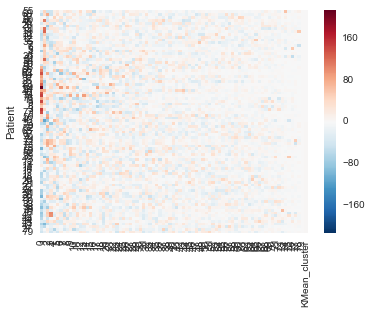

In [95]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
kmean_final = KMeans(n_clusters=3, max_iter=10)
kmean_final = kmean_final.fit(data)
kmean_plot = pd.DataFrame(data)
kmean_plot['KMean_cluster'] = kmean_final.labels_
kmean_plot.sort('KMean_cluster',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
kmean_plot.index.name = 'Patient'
sb.heatmap(kmean_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!

# Spectral Clustering

In [83]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6]
 
def compare_spectral(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = SpectralClustering(n_clusters=k, gamma = 0.0001, n_jobs=4)
        clusterer.fit(data)
        silhouette = metrics.silhouette_score(data, clusterer.labels_)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], clusterer.labels_)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_spectral(n_clusters, data)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: 0.0273
Homogeneity score: 0.0359
Adjusted Rand Index 0.0192

------------ k= 3 --------
Silhouette Coefficient: 0.011
Homogeneity score: 0.0569
Adjusted Rand Index 0.0119

------------ k= 4 --------
Silhouette Coefficient: 0.0223
Homogeneity score: 0.0801
Adjusted Rand Index 0.019

------------ k= 5 --------
Silhouette Coefficient: 0.0193
Homogeneity score: 0.1056
Adjusted Rand Index 0.0204

------------ k= 6 --------
Silhouette Coefficient: 0.014
Homogeneity score: 0.1395
Adjusted Rand Index 0.0303


------------Results------------
k with highest silhouette coefficient: 2 0.027348883185
k with highest homogeneity score: 6 0.139459435515
k with adjusted rand index score: 6 0.0302578537284


In [84]:
spectral_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(spectral_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

,k = 2,k = 3,k = 4,k = 5,k = 6
Silhouette Coeff.,0.027349,0.011047,0.022290,0.019306,0.013981
Homogeneity Score,0.035944,0.056917,0.080124,0.105634,0.139459
Adjusted Rand Index,0.019159,0.011910,0.019033,0.020449,0.030258


/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


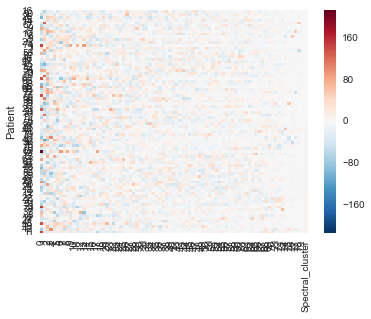

In [94]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
spectral_final = SpectralClustering(n_clusters=6)
spectral_final = spectral_final.fit(data)
spectral_plot = pd.DataFrame(data)
spectral_plot['Spectral_cluster'] = spectral_final.labels_
spectral_plot.sort('Spectral_cluster',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
spectral_plot.index.name = 'Patient'
sb.heatmap(spectral_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!

# Gaussian Mixture Models

In [89]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6]
 
def compare_GMM(k_list,data):
    ## Run clustering with different k and check the metrics
    s_scores, h_scores, r_scores = [], [], []
    
    for k in k_list:
        clusterer = GaussianMixture(n_components=k)
        clusterer.fit(data)
        labels = clusterer.predict(data)
        silhouette = metrics.silhouette_score(data, labels)
        homogeneity = metrics.homogeneity_score(processed['PAM50 mRNA'], labels)
        rand = metrics.adjusted_rand_score(processed['PAM50 mRNA'], labels)

        s_scores.append(silhouette)
        h_scores.append(homogeneity)
        r_scores.append(rand)
        
        ## The higher (up to 1) the better
        print "------------ k=",k, "--------"
        print "Silhouette Coefficient:", round(silhouette, 4)
        ## The higher (up to 1) the better
        print "Homogeneity score:", round(homogeneity,4)
        ## The higher (up to 1) the better
        print "Adjusted Rand Index", round(rand,4)
        print 
        
    return s_scores, h_scores, r_scores
 
## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)
 
 
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
s_scores, h_scores, r_scores = compare_GMM(n_clusters, data)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.
 
## Use random proteins for comparison
# compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

print
print("------------Results------------")

print "k with highest silhouette coefficient:", n_clusters[np.array(s_scores).argmax()], np.max(s_scores)
print "k with highest homogeneity score:", n_clusters[np.array(h_scores).argmax()], np.max(h_scores)
print "k with adjusted rand index score:", n_clusters[np.array(r_scores).argmax()], np.max(r_scores)

------------ k= 2 --------
Silhouette Coefficient: 0.1434
Homogeneity score: 0.0119
Adjusted Rand Index 0.0085

------------ k= 3 --------
Silhouette Coefficient: 0.09
Homogeneity score: 0.0568
Adjusted Rand Index 0.0113

------------ k= 4 --------
Silhouette Coefficient: 0.0461
Homogeneity score: 0.1462
Adjusted Rand Index 0.0902

------------ k= 5 --------
Silhouette Coefficient: 0.0247
Homogeneity score: 0.1611
Adjusted Rand Index 0.0759

------------ k= 6 --------
Silhouette Coefficient: 0.0359
Homogeneity score: 0.2362
Adjusted Rand Index 0.1152


------------Results------------
k with highest silhouette coefficient: 2 0.1433719547
k with highest homogeneity score: 6 0.236191830242
k with adjusted rand index score: 6 0.115210974127


In [90]:
gmm_metrics = np.array([s_scores, h_scores, r_scores])
pd.DataFrame(gmm_metrics, columns=["k = "+str(k) for k in n_clusters], index=["Silhouette Coeff.", "Homogeneity Score", "Adjusted Rand Index"])

,k = 2,k = 3,k = 4,k = 5,k = 6
Silhouette Coeff.,0.143372,0.090003,0.046101,0.024691,0.035942
Homogeneity Score,0.011910,0.056828,0.146212,0.161104,0.236192
Adjusted Rand Index,0.008540,0.011259,0.090183,0.075913,0.115211


/Users/RichardChen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


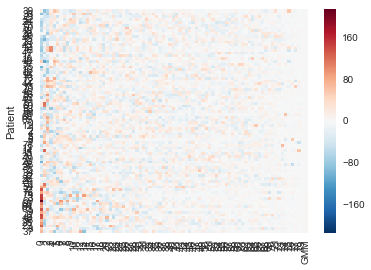

In [93]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
gmm_final = GaussianMixture(n_components=3)
gmm_final = gmm_final.fit(data)
gmm_plot = pd.DataFrame(data)
gmm_plot['GMM'] = gmm_final.predict(data)
gmm_plot.sort('GMM',axis=0,inplace=True)
 
## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
gmm_plot.index.name = 'Patient'
sb.heatmap(gmm_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!
 
## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!